In [81]:
from configparser import ConfigParser
import configparser
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


In [82]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [83]:
#Establish the connection and create a curose to the database 
def connect(cfg):
    try:
        print("Attempting to connect to the database")
        conn = psycopg2.connect(**cfg)
        cursor = conn.cursor()
        print("Connected!")
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    return conn, cursor 

def close_connection(connection, cursor):
    print("Closing connection")
    cursor.close()
    connection.close()
    print("Connection closed!")

In [84]:
def fetch(cursor, query):
    """
    Fetch the data from the db 
    """
    print("Fetching query...")
    # Get the features and labels
    try:
        cursor.execute(query)
        #Get the complete result set: list of tuples where each tuple is a row from the result set 
        result_list = cursor.fetchall()
        print("Fetched!")
        return result_list
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [85]:
def load_config(config_file):
    # Read the config file 
    config = configparser.ConfigParser()
    config.read(config_file)
    # Clean up sql_query 
    sql_query = config['DEFAULT']['sql_query'].replace('\n', ' ').strip()
    columns = config['DEFAULT']['columns'].split(', ')
    categorical_col_list = config['DEFAULT']['categorical_col_list'].split(', ')
    numeric_col_list = config['DEFAULT']['numeric_col_list'].split(', ')
    label = config['DEFAULT']['label']
    labels_to_drop = config['DEFAULT']['labels_to_drop']
    if labels_to_drop:
        labels_to_drop = config['DEFAULT']['labels_to_drop'].split(', ')
    return sql_query, columns, categorical_col_list, numeric_col_list, label, labels_to_drop

In [86]:
def load_data():
    print("Loading data...")
    # Get the configuration file as a python dict
    cfg = config()
    # Connect to the database
    conn, cursor = connect(cfg)
    # Fetch the data
    result_list = fetch(cursor, sql_query)
    # Load results in datafram
    result_df = load(result_list, columns)
    print("Data loaded into dataframe!")
    return result_df

In [87]:
def load(result_list, cols):
    """
    Load data in a dataframe
    """
    print("Loading data in dataframe")
    result_df = pd.DataFrame(result_list, columns=cols)
    return result_df

In [88]:
sql_query, columns, categorical_col_list, numeric_col_list, label, labels_to_drop = load_config('summerization_config.ini')

def get_data():
    result_df = load_data()
    X, y = data_transform(result_df, top_k)
    return X, y

In [89]:
data = load_data()

Loading data...
Attempting to connect to the database
Connected!
Fetching query...
Fetched!
Loading data in dataframe
Data loaded into dataframe!


In [90]:
data.tail()

,gender,age_group,outbreak_related,month_name,is_holiday,season,is_weekend,title,phu_name,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,resolved,unresolved,fatal
148048,MALE,<20,No,November,False,Fall,False,workplace_closure,Toronto Public Health,-44.00000,-10.00000,-9.00000,-60.00000,-48.00000,20.00000,yes,no,no
148049,FEMALE,50s,No,January,False,Winter,False,stay_at_home,Toronto Public Health,-59.00000,-27.00000,-27.00000,-70.00000,-58.00000,23.00000,yes,no,no
148050,FEMALE,50s,Yes,October,False,Fall,False,school_closure,Toronto Public Health,-38.00000,-7.00000,5.00000,-54.00000,-46.00000,19.00000,yes,no,no
148051,MALE,70s,Yes,October,False,Fall,False,school_closure,Toronto Public Health,-35.00000,-8.00000,69.00000,-50.00000,-45.00000,16.00000,no,no,yes
148052,MALE,40s,No,December,False,Winter,True,stay_at_home,Toronto Public Health,-47.00000,-8.00000,5.00000,-68.00000,-64.00000,23.00000,yes,no,no


In [91]:
fatal_df = data[data["fatal"] == "yes"]

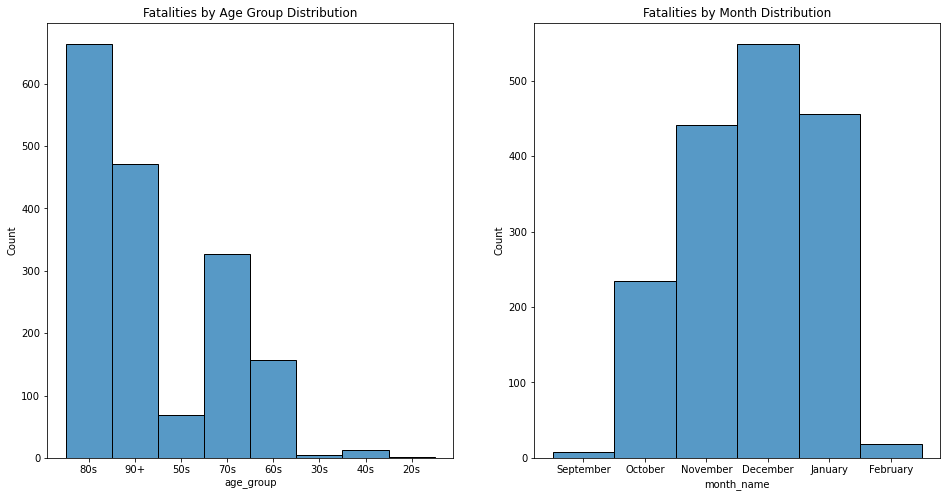

In [92]:
def month_sorter(column):
    teams = ['September','October','November', 'December', 'January', 'February']
    correspondence = {team: order for order, team in enumerate(teams)}
    return column.map(correspondence)


month_sorted_df= fatal_df.sort_values(by='month_name', key=month_sorter)

fig, axs = plt.subplots(ncols=2)
order_list = ['September','October','November', 'December', 'January', 'February']
sns.histplot(fatal_df["age_group"], ax=axs[0]).set(title='Fatalities by Age Group Distribution')
sns.histplot(month_sorted_df["month_name"],ax=axs[1]).set(title='Fatalities by Month Distribution')

fig.set_size_inches(16, 8)

Age Group:
- Most fatalities occured in people in their 80s
- least in people in their 20s and no fatalities for people less than 20

Month:
- Significantly more fatalities in November, December and January compared to October, February and September
- Most fatalities occur in December, Least in September

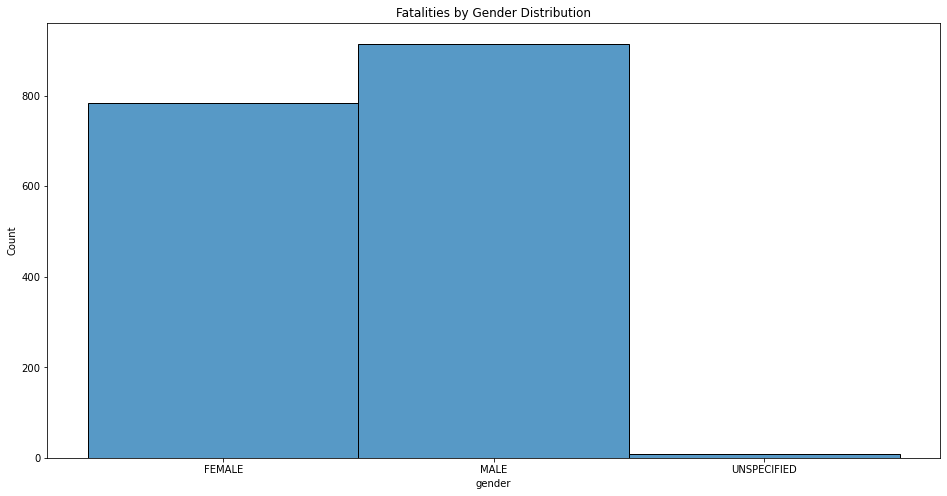

In [93]:
fig, ax = plt.subplots()
sns.histplot(fatal_df["gender"], ax=ax).set(title='Fatalities by Gender Distribution')
fig.set_size_inches(16, 8)



Most fatalities occures in men, but not by a significant amount. There are a few fatalities of those of unspecified gender.

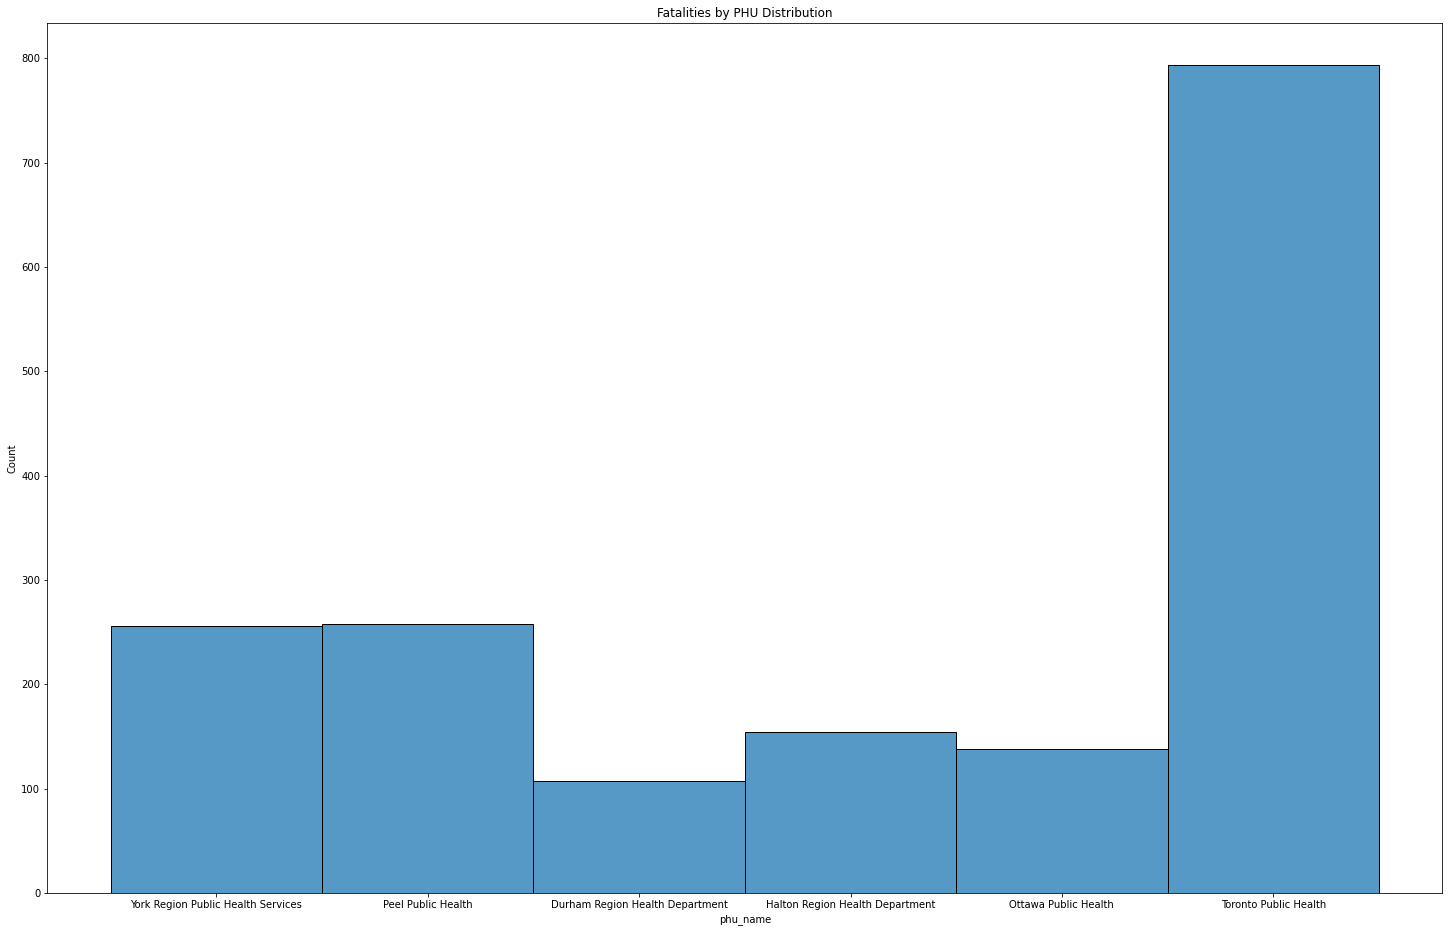

In [94]:
fig, ax = plt.subplots()
sns.histplot(fatal_df["phu_name"], ax=ax).set(title='Fatalities by PHU Distribution')
fig.set_size_inches(25, 16)

The most fatalities occured in the Totonto Public Health Unit PHU.  The least amount of fatalities occures in the Durham Region Health Department,

In [95]:
query = "Select retail_and_recreation, grocery_and_pharmacy, parks, transit_stations, workplaces, residential From covid.mobility;"

sql_query = query
columns = ["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential"]

mobility_data = load_data()

Loading data...
Attempting to connect to the database
Connected!
Fetching query...
Fetched!
Loading data in dataframe
Data loaded into dataframe!


In [96]:
mobility_data.head()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,-28.00000,-6.00000,-4.00000,-64.00000,-53.00000,18.00000
1,-32.00000,-9.00000,-26.00000,-68.00000,-53.00000,19.00000
2,-24.00000,3.00000,5.00000,-61.00000,-52.00000,18.00000
3,-29.00000,0.00000,19.00000,-57.00000,-50.00000,17.00000
4,-29.00000,1.00000,89.00000,-49.00000,-4.00000,6.00000


[Text(0.5, 1.0, 'Distribution of Location Mobility')]

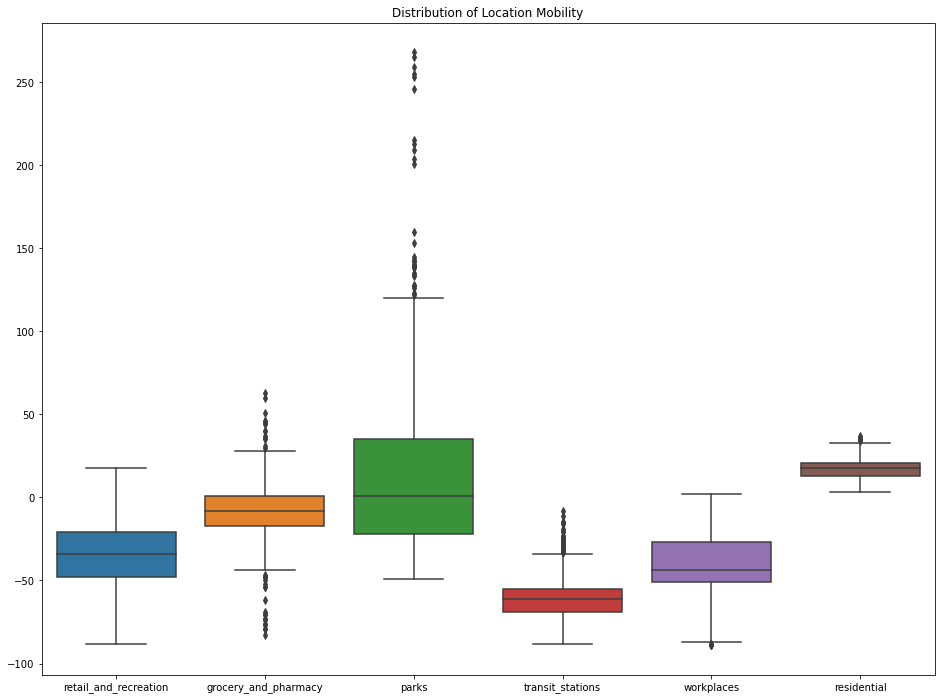

In [97]:
plt.figure(figsize=(16, 12))

sns.boxplot(data=mobility_data).set(title="Distribution of Location Mobility")

In [98]:
sql_query = """select M.date, M.subregion, M.retail_and_recreation, M.grocery_and_pharmacy, M.parks, M.transit_stations, M.workplaces, M.residential,
D.day_name, D.holiday_name, D.is_holiday, D.is_weekday, D.is_weekend, D.month_name
from covid.mobility_dated_copy as M, covid.date as D
where M.date = D.date;"""

columns = ["date", "subregion", "retail_and_recreation", "grocery_and_pharmacy", "parks", 
           "transit_stations", "workplaces", "residential", "day_name", "holiday_name", "is_holiday", "is_weekday",
          "is_weekend", "month"]

mobility_dated_data = load_data()

Loading data...
Attempting to connect to the database
Connected!
Fetching query...
Fetched!
Loading data in dataframe
Data loaded into dataframe!


In [99]:
mobility_dated_data.head()

,date,subregion,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,day_name,holiday_name,is_holiday,is_weekday,is_weekend,month
0,2020-10-06,Ottawa Division,-28,-6,-4,-64,-53,18,Tuesday,NoHoliday,False,True,False,October
1,2020-10-07,Ottawa Division,-32,-9,-26,-68,-53,19,Wednesday,NoHoliday,False,True,False,October
2,2020-10-08,Ottawa Division,-24,3,5,-61,-52,18,Thursday,NoHoliday,False,True,False,October
3,2020-10-09,Ottawa Division,-29,0,19,-57,-50,17,Friday,NoHoliday,False,True,False,October
4,2020-10-10,Ottawa Division,-29,1,89,-49,-4,6,Saturday,NoHoliday,False,False,True,October


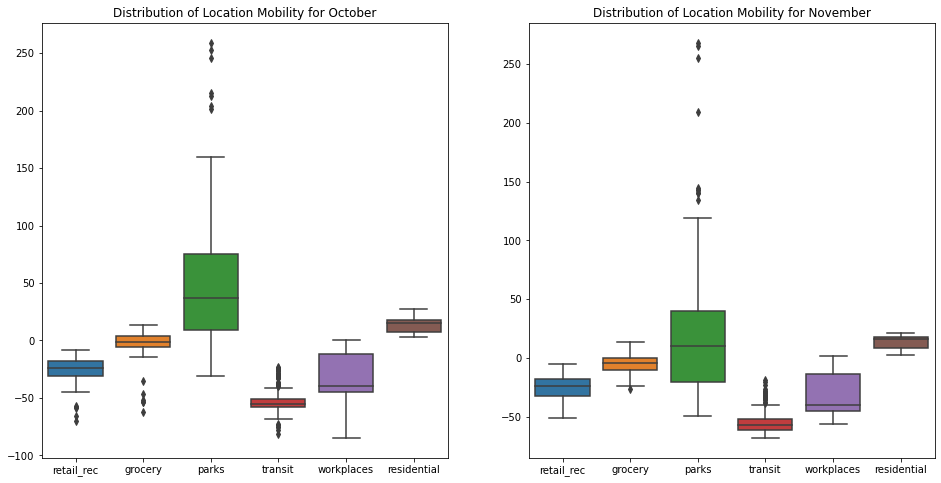

In [100]:
short_columns = ["retail_rec", "grocery", "parks", "transit", "workplaces", "residential"]

october = mobility_dated_data[mobility_dated_data["month"] == "October"]
october_mobility = october[["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential" ]]
november = mobility_dated_data[mobility_dated_data["month"] == "November"]
november_mobility = november[["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential" ]]
december = mobility_dated_data[mobility_dated_data["month"] == "December"]
december_mobility = december[["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential" ]]
january = mobility_dated_data[mobility_dated_data["month"] == "January"]
january_mobility = january[["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential" ]]
february = mobility_dated_data[mobility_dated_data["month"] == "February"]
february_mobility = february[["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit_stations", "workplaces", "residential" ]]

october_mobility.columns = short_columns
november_mobility.columns = short_columns
december_mobility.columns = short_columns
january_mobility.columns = short_columns
february_mobility.columns = short_columns


fig, ax = plt.subplots(ncols=2)
sns.boxplot(data=october_mobility, ax=ax[0]).set(title="Distribution of Location Mobility for October")
sns.boxplot(data=november_mobility, ax=ax[1]).set(title="Distribution of Location Mobility for November")
fig.set_size_inches(16, 8)

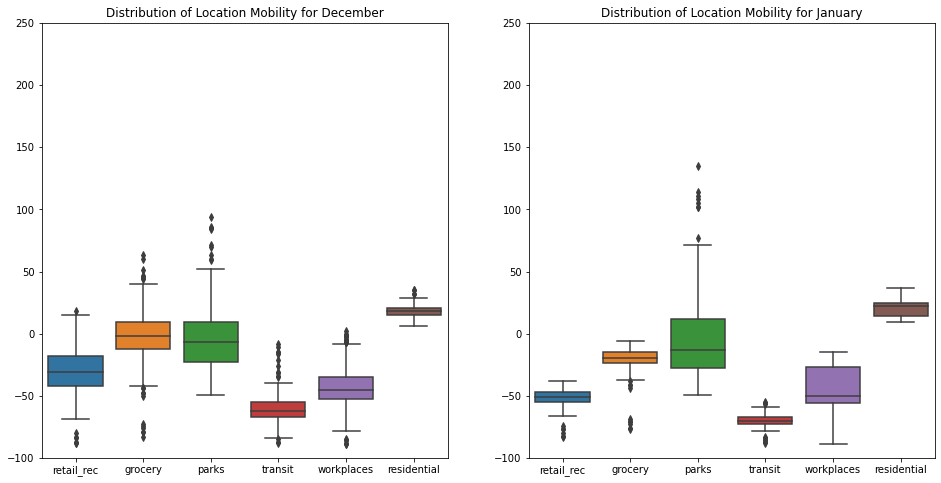

In [101]:
fig, ax = plt.subplots(ncols=2)
sns.boxplot(data=december_mobility, ax=ax[0]).set(title="Distribution of Location Mobility for December")
sns.boxplot(data=january_mobility, ax=ax[1]).set(title="Distribution of Location Mobility for January")
ax[0].set_ylim(-100, 250)
ax[1].set_ylim(-100, 250)
fig.set_size_inches(16, 8)

In [102]:
x = october[october["parks"] > 200]

In [103]:
x.head(10)

,date,subregion,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,day_name,holiday_name,is_holiday,is_weekday,is_weekend,month
252,2020-10-10,Regional Municipality of Halton,-21,12,215,-29,-4,5,Saturday,NoHoliday,False,False,True,October
254,2020-10-12,Regional Municipality of Halton,-59,-54,259,-78,-85,25,Monday,Thanksgiving,True,True,False,October
259,2020-10-17,Regional Municipality of Halton,-13,10,246,-23,-2,6,Saturday,NoHoliday,False,False,True,October
500,2020-10-10,Regional Municipality of York,-23,9,213,-33,-5,6,Saturday,NoHoliday,False,False,True,October
501,2020-10-11,Regional Municipality of York,-23,6,204,-40,-7,4,Sunday,NoHoliday,False,False,True,October
502,2020-10-12,Regional Municipality of York,-45,-35,201,-73,-83,26,Monday,Thanksgiving,True,True,False,October
507,2020-10-17,Regional Municipality of York,-17,8,253,-33,-1,6,Saturday,NoHoliday,False,False,True,October


Text(0, 0.5, 'Residential mobility')

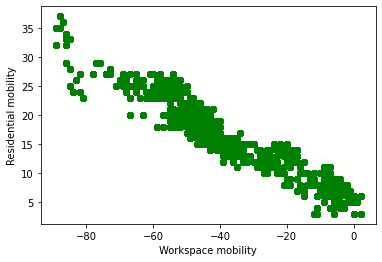

In [104]:
x = data['workplaces']
y = data['residential'] 
plt.scatter(x, y, c='green') 
plt.xlabel('Workspace mobility') 
plt.ylabel('Residential mobility')

# Scatter plot graph shows some correlation between workspace and residential mobility.
# Workspace and residential mobility are inversially proportional to each other.

Text(0, 0.5, 'Grocery/Pharmacy mobility')

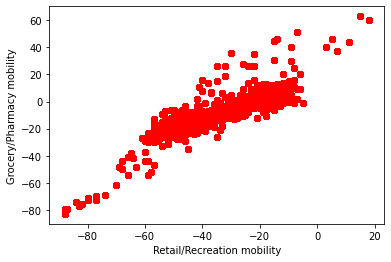

In [105]:
x = data['retail_and_recreation']
y = data['grocery_and_pharmacy'] 
plt.scatter(x, y, c='red') 
plt.xlabel('Retail/Recreation mobility') 
plt.ylabel('Grocery/Pharmacy mobility')

# Scatter plot graph shows some correlation between retail/recreation and grocery/pharmacy mobility.
# Workspace and residential mobility are proportional to each other.

Text(0, 0.5, 'Parks mobility')

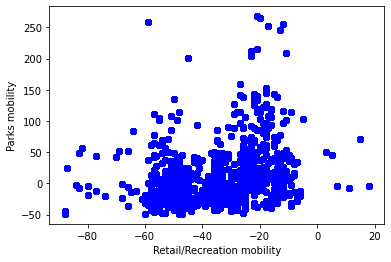

In [106]:
x = data['retail_and_recreation']
y = data['parks'] 
plt.scatter(x, y, c='blue') 
plt.xlabel('Retail/Recreation mobility') 
plt.ylabel('Parks mobility')

# Scatter plot graph shows no true correlation between retail/recreation and parks mobility.

Text(0, 0.5, 'Parks mobility')

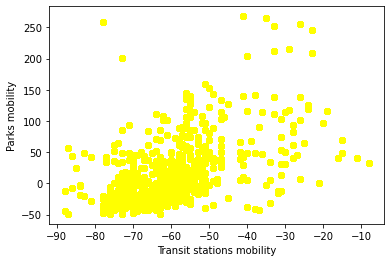

In [107]:
x = data['transit_stations']
y = data['parks'] 
plt.scatter(x, y, c='yellow') 
plt.xlabel('Transit stations mobility') 
plt.ylabel('Parks mobility')

# Scatter plot graph shows no true correlation between transit/parks and parks mobility.

Text(0, 0.5, 'Residential mobility')

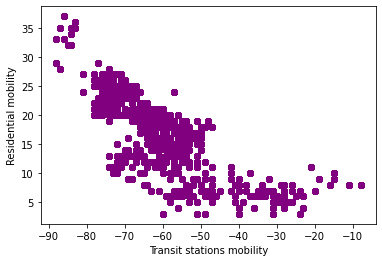

In [108]:
x = data['transit_stations']
y = data['residential'] 
plt.scatter(x, y, c='purple') 
plt.xlabel('Transit stations mobility') 
plt.ylabel('Residential mobility')

# Scatter plot graph shows some kind of correlation between retail/recreation and parks mobility.